<a href="https://colab.research.google.com/github/Steven-Macas/kmeans_paises/blob/main/paises_aprendizaje_automatico_no_supervisado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***APRENDIZAJE AUTOMÁTICO***

---



***NO SUPERVISADO***

En el dataset se encuentran datos relativos a factores socioeconómicos y de salud que determinan el desarrollo de un país.

## ***Librerías***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy import stats
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import OneHotEncoder

## **Cargar DataSet y primera vista**

In [2]:
df = pd.read_csv('Country-data.csv', index_col='country');

In [3]:
df.tail()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
country,,,,,,,,,
Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970
Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500
Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310
Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310
Zambia,83.1,37.0,5.89,30.9,3280,14.00,52.0,5.40,1460


child_mort: Muerte de niños menores de 5 años por cada 1000 nacidos vivos

exports: Exportaciones de bienes y servicios per cápita. Dado como % de edad del PIB per cápita

health: Total en salud per cápita. Dado como % de edad del PIB per cápita

imports:Importaciones de bienes y servicios per cápita. Dado como % de edad del PIB per cápita

incom: ingresos netos por persona

life_expec: El número promedio de años que viviría un recién nacido si los patrones de mortalidad actuales se mantuvieran iguales.

total_fer: El número de hijos que nacerían de cada mujer si las tasas actuales de edad y fecundidad siguen siendo las mismas.

dppp: El PIB per cápita. Calculado como el PIB total dividido por la población total.

In [4]:
df.dtypes

child_mort    float64
exports       float64
health        float64
imports       float64
income          int64
inflation     float64
life_expec    float64
total_fer     float64
gdpp            int64
dtype: object

## ***Preprocesar los datos***

In [8]:
df.isnull().sum()

child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [5]:
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


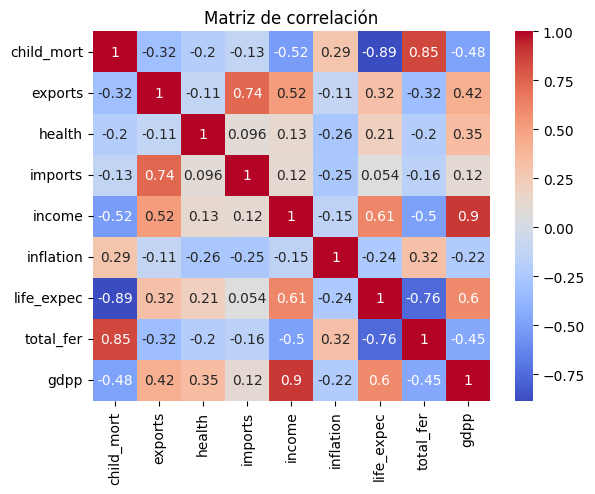

In [6]:
# Realizamos un pequeño análisis estadístico para elegir las variables más relevantes
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.title('Matriz de correlación')
plt.show()

## ***Escalar y detectar OutLiers***

In [11]:
# Elegimos las variables con mayor correlación con la variable objetivo y las que menos se relacionen entre sí
#relevant_variables = []

<ipython-input-7-b5273d12130e>:1: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df[df.columns].hist(ax = plt.figure(figsize = (15, 15)).gca())


array([[<Axes: title={'center': 'child_mort'}>,
        <Axes: title={'center': 'exports'}>,
        <Axes: title={'center': 'health'}>],
       [<Axes: title={'center': 'imports'}>,
        <Axes: title={'center': 'income'}>,
        <Axes: title={'center': 'inflation'}>],
       [<Axes: title={'center': 'life_expec'}>,
        <Axes: title={'center': 'total_fer'}>,
        <Axes: title={'center': 'gdpp'}>]], dtype=object)

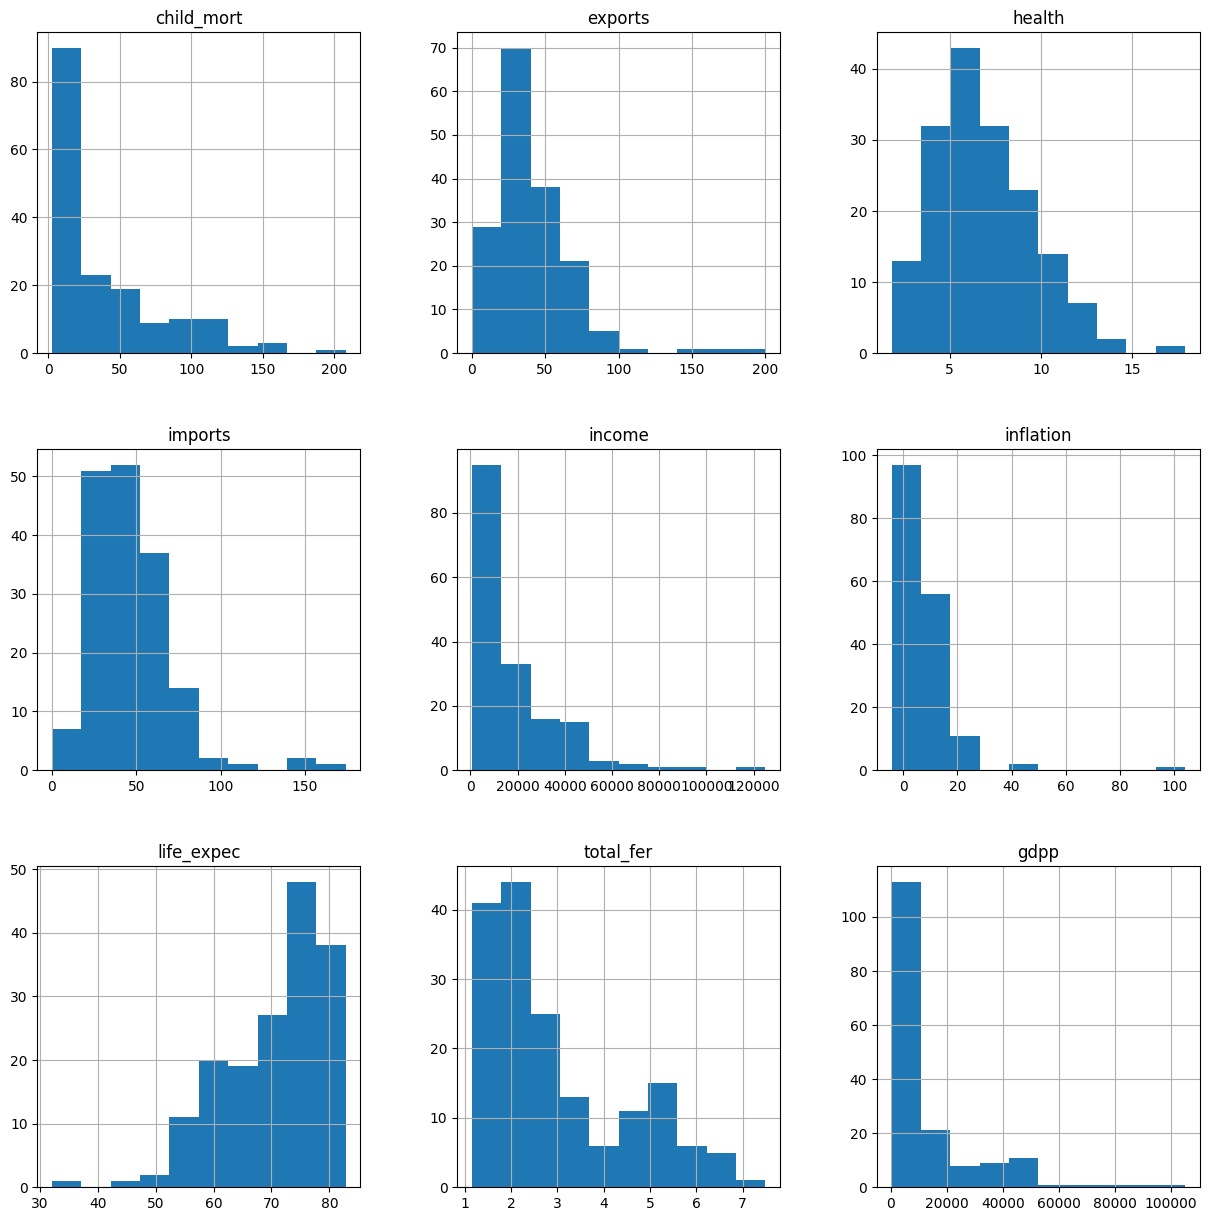

In [7]:
df[df.columns].hist(ax = plt.figure(figsize = (15, 15)).gca())

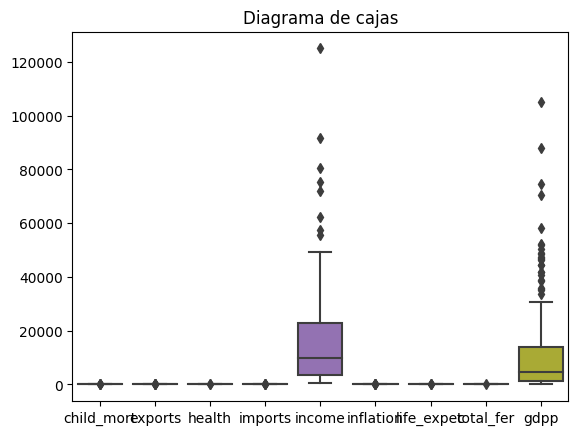

In [8]:
# Verificamos si es necesario escalar las variables
sns.boxplot(df)
plt.title('Diagrama de cajas')
plt.show()

el diagrama de cajas se utiliza para verificar si es necesario escalar las variables de los datos. Si se observan valores atípicos en el diagrama de cajas, podría ser necesario escalar las variables para reducir el efecto de estos valores extremos en el análisis posterior

In [9]:
import seaborn as sns

# mediante esta función de pueden visualizar los 'outliers'
def draw_hist_boxplot(df, feature_name):
  # se dibuja el diagrama de cajas
  sns.boxplot(x = feature_name, data = df)
  # se dibujan sobre el diagrama todos los puntos de datos que tiene la propiedad
  sns.stripplot(x = feature_name, data = df, color = "#474646")

# mediante esta función se reemplazan todos los outliers
# cualquier valor por encima o por debajo de los
# límites superior o inferior es sustituido por la mediana
def replace_outliers_with_median(df, feature_name):
  Q1 = df[feature_name].quantile(0.25)
  median = df[feature_name].quantile(0.5)
  Q3 = df[feature_name].quantile(0.75)
  IQR = Q3 - Q1
  lower_whisker = Q1 - 1.5 * IQR
  upper_whisker = Q3 + 1.5 * IQR
  df[feature_name] = np.where((df[feature_name] < lower_whisker) | 
                              (df[feature_name] > upper_whisker), 
                                median, 
                                df[feature_name])

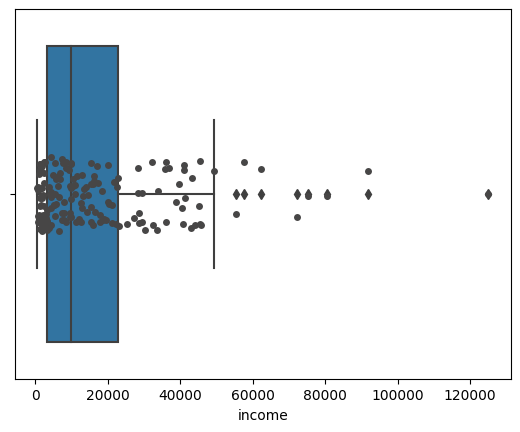

In [10]:
draw_hist_boxplot(df, 'income')

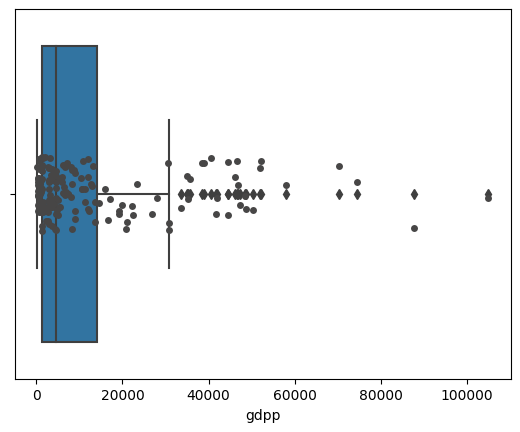

In [11]:
draw_hist_boxplot(df, 'gdpp')

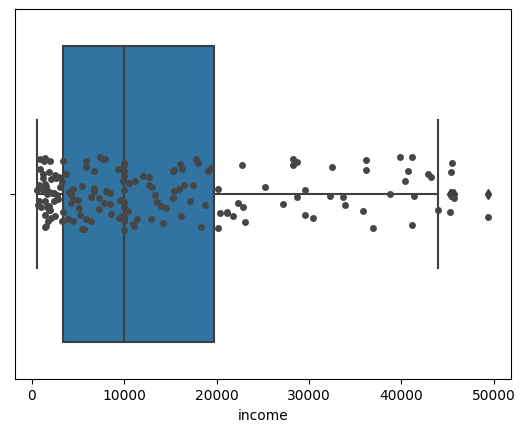

In [12]:
replace_outliers_with_median(df, 'income')
draw_hist_boxplot(df, 'income')

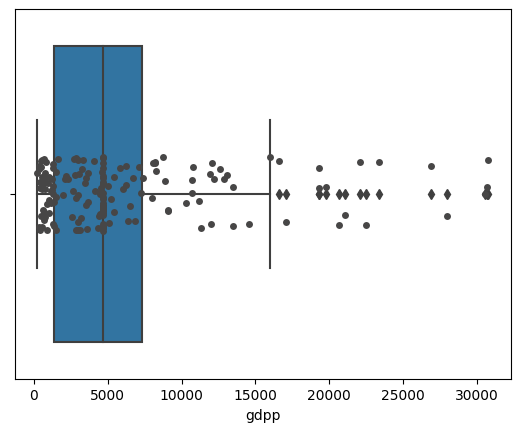

In [13]:
replace_outliers_with_median(df, 'gdpp')
draw_hist_boxplot(df, 'gdpp')

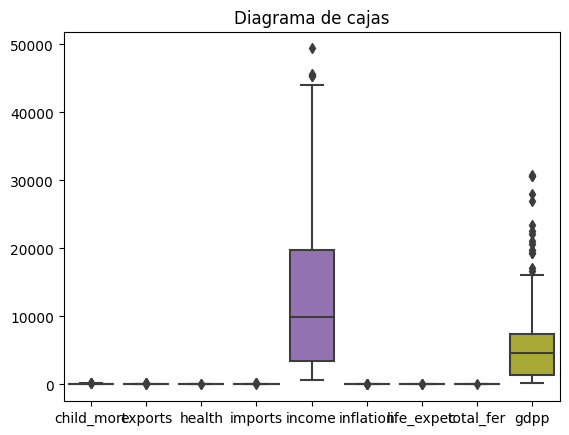

In [14]:
# Verificamos si es necesario escalar las variables
sns.boxplot(df)
plt.title('Diagrama de cajas')
plt.show()

<ipython-input-15-b5273d12130e>:1: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df[df.columns].hist(ax = plt.figure(figsize = (15, 15)).gca())


array([[<Axes: title={'center': 'child_mort'}>,
        <Axes: title={'center': 'exports'}>,
        <Axes: title={'center': 'health'}>],
       [<Axes: title={'center': 'imports'}>,
        <Axes: title={'center': 'income'}>,
        <Axes: title={'center': 'inflation'}>],
       [<Axes: title={'center': 'life_expec'}>,
        <Axes: title={'center': 'total_fer'}>,
        <Axes: title={'center': 'gdpp'}>]], dtype=object)

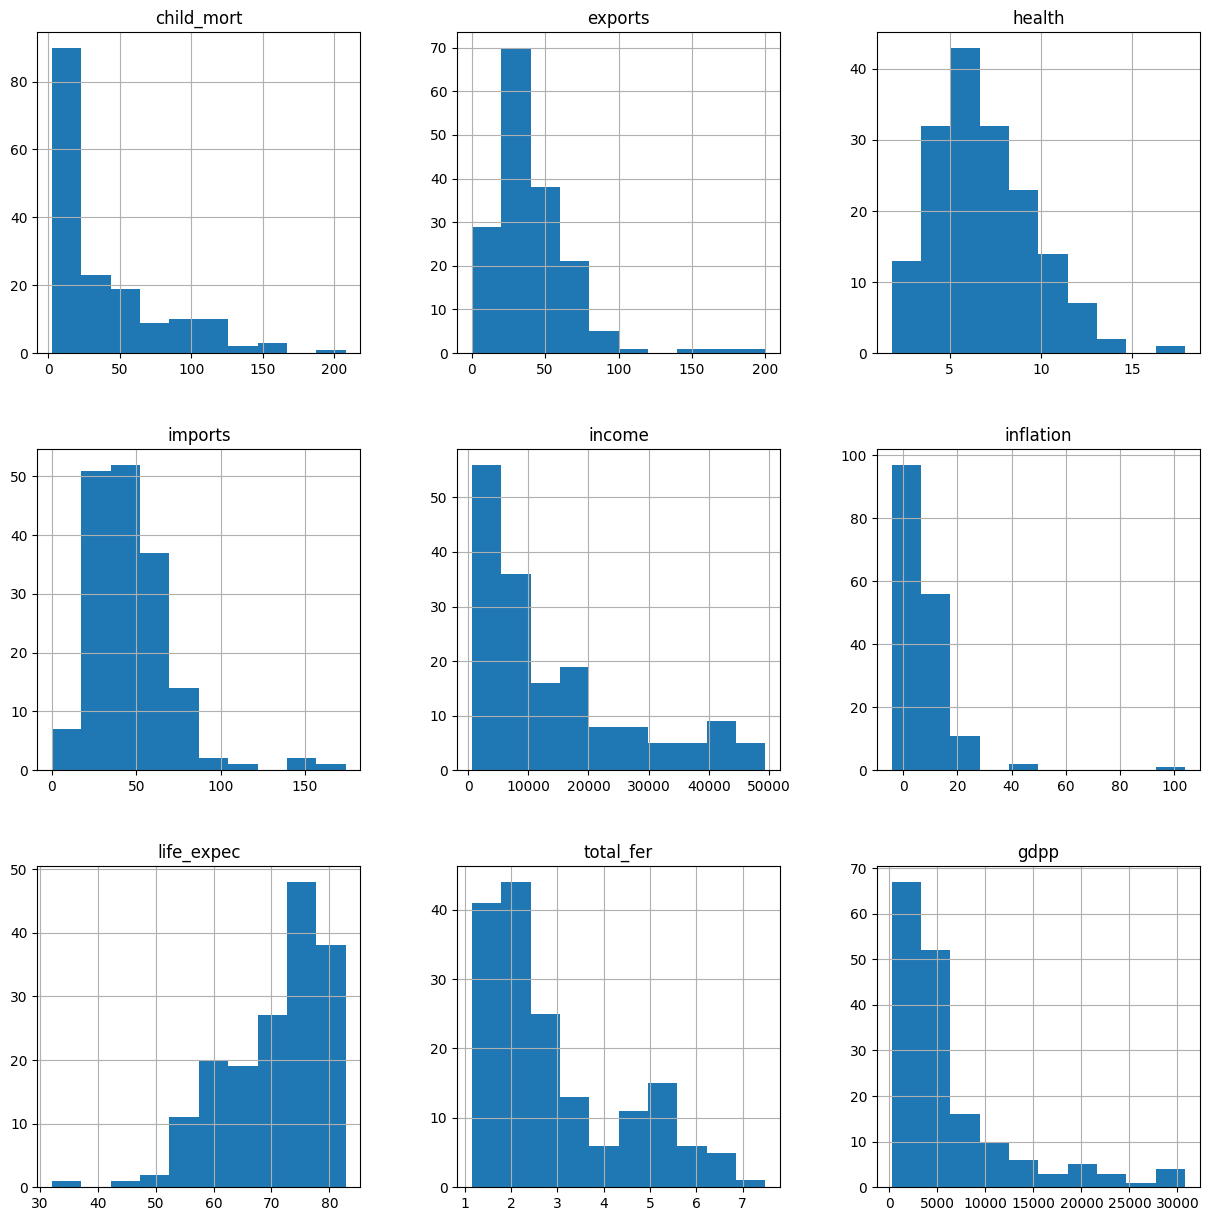

In [15]:
df[df.columns].hist(ax = plt.figure(figsize = (15, 15)).gca())

In [16]:
x = df.to_numpy()
N = x.shape[0]

In [17]:
# Como se observa una diferencia de magnitud entre las variables, se procede a escalarlas
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df)

In [18]:
# Detectamos outliers y eliminamos
# Utilizamos el método de Jacknife y el algoritmo K-means
sse = []
for i in range(len(data_scaled)):
  X = np.delete(data_scaled, i, axis=0)
  kmeans = KMeans(n_clusters=4, n_init=10, random_state=100).fit(X)
  sse.append(kmeans.inertia_)

In [19]:
sigma = np.std(sse)
mu = np.mean(sse)
umbral = 2
outliers = []
for i in range(0,N):
  if np.abs(sse[i]-mu) > umbral*sigma:
    outliers.append(i)

In [20]:
outliers

[21, 27, 36, 40, 41, 113, 133]

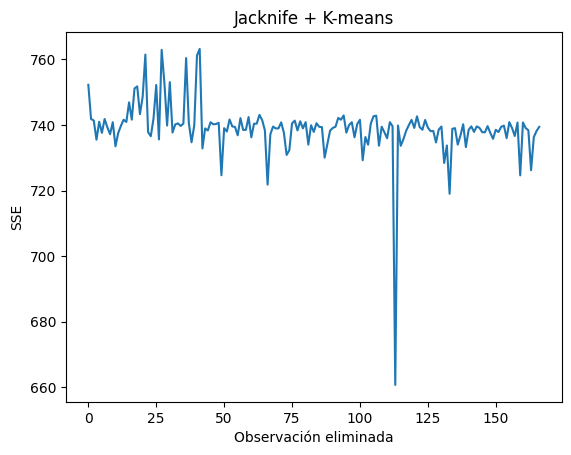

In [21]:
# Graficamos el índice SSE de cada ejecución
plt.plot(sse)
plt.title('Jacknife + K-means')
plt.xlabel('Observación eliminada')
plt.ylabel('SSE')
plt.show()

In [22]:
sse = []
for i in range(data_scaled.shape[0]):
    j_indices = [j for j in range(data_scaled.shape[0]) if j != i]
    kmeans_j = KMeans(n_clusters=4, n_init=10, random_state=0).fit(data_scaled[j_indices])
    sse.append(kmeans_j.inertia_)

## **Análisis Cluster**

In [23]:
# Ejecución de análisis cluster con un valor de k concreto y determinar el número de réplicas (n_init)
# que conduce a que la repetición de dicho algoritmo genere la misma solución
kmeans = KMeans(n_clusters=4, n_init=10, random_state=0).fit(data_scaled)
print('Silhouette score:', silhouette_score(data_scaled, kmeans.labels_))
print('Davies-Bouldin score:', davies_bouldin_score(data_scaled, kmeans.labels_))

Silhouette score: 0.24281887253540757
Davies-Bouldin score: 1.2360068427133049


In [24]:
centroids = kmeans.cluster_centers_
centroids

array([[-0.27983205, -0.04596724, -0.39946465, -0.0644826 , -0.34746329,
         0.12648621,  0.06074514, -0.28743049, -0.24827736],
       [ 1.47983888, -0.49968714, -0.19065106, -0.17024747, -0.85330521,
         0.42033876, -1.29336108,  1.48058222, -0.71664775],
       [-0.77302579,  0.14646234,  0.73022741, -0.08846639,  1.1598312 ,
        -0.46779984,  0.90328903, -0.75357425,  0.88055509],
       [-0.78516853,  4.18374672, -0.31793189,  4.04399055,  0.25246434,
        -0.66261764,  1.00031644, -0.90800806,  0.64257767]])

## **Numero de grupos**

In [25]:
# Determinar el valor de k (número de grupos) optimizando la función BIC
bic = []
for k in range(2, 10):
    kmeans_k = KMeans(n_clusters=k, n_init=10, random_state=0).fit(data_scaled)
    bic.append(kmeans_k.score(data_scaled) + np.log(data_scaled.shape[0]) * k)

In [26]:
bic

[-1023.1942994294203,
 -853.5714373072617,
 -720.091240557861,
 -638.194623626506,
 -552.842965331316,
 -490.313854434513,
 -440.8490215417338,
 -401.00872219130105]

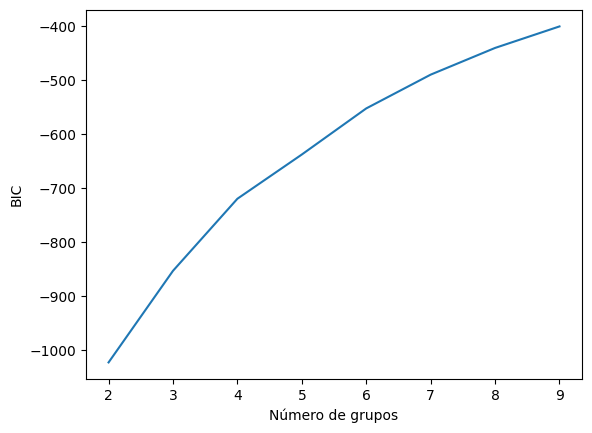

In [27]:
# Se grafica el valor BIC en función del número de grupos
plt.plot(range(2, 10), bic)
plt.xlabel('Número de grupos')
plt.ylabel('BIC')
plt.show()

In [28]:
from sklearn.mixture import GaussianMixture
def get_bic(k, X):
    gmm = GaussianMixture(n_components=k, init_params='kmeans')
    gmm.fit(X)
    return k, gmm.bic(X)

In [29]:
bic_score = pd.DataFrame([get_bic(k, X) for k in range(2, 30)], columns=['k', 'BIC'])

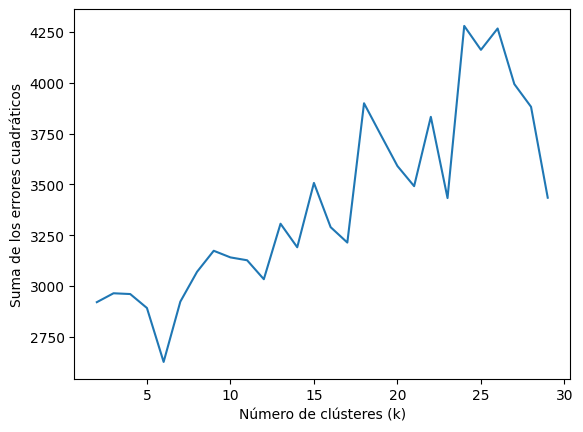

In [30]:
plt.xlabel('Número de clústeres (k)')
plt.ylabel('Suma de los errores cuadráticos')
plt.plot(bic_score['k'],bic_score['BIC'])

In [31]:
k_optimized = bic_score[bic_score.BIC == bic_score.BIC.min()]
k_optimized

,k,BIC
4,6,2627.161503


## **Análisis - Datos Calculados**

In [32]:
# Ejecución de análisis con los datos calculados (k y n_init)
kmeans_final = KMeans(n_clusters=k, n_init=10, random_state=0).fit(data_scaled)

In [33]:
kmeans_final.cluster_centers_

array([[-1.96215026e-01, -3.22570149e-01, -7.74545992e-01,
        -7.11704617e-01, -3.15111735e-01,  5.58873697e-01,
         1.38883140e-01, -2.52773054e-01, -2.53037795e-01],
       [-6.51027366e-01, -8.66101935e-02,  4.42934556e-01,
        -8.81615973e-03,  8.01307077e-03, -3.51510733e-01,
         5.52545757e-01, -7.87305472e-01,  2.97679005e-01],
       [-8.42224767e-01,  4.68081927e-02,  1.42823656e+00,
        -3.09589802e-01,  2.07653963e+00, -6.20111686e-01,
         1.15672131e+00, -7.48507649e-01, -2.17862016e-01],
       [-8.49003244e-01,  4.93567278e+00, -8.16303241e-03,
         4.54805768e+00,  1.68329276e-01, -5.04206141e-01,
         1.22682431e+00, -1.03886271e+00,  6.17427527e-01],
       [ 1.37609265e+00, -4.20439676e-01, -5.85404217e-01,
        -3.30777072e-01, -8.24149273e-01,  3.17351885e-01,
        -1.15703006e+00,  1.57595270e+00, -6.89641513e-01],
       [-7.72069973e-01,  3.96551920e-01,  1.22804077e-01,
         3.13399267e-02,  1.36307308e+00, -3.444757

In [34]:
np.array(kmeans_final.cluster_centers_[0][0])

array(-0.19621503)

## **Resultados**

In [77]:
# Mostrar para el análisis anterior una tabla con los siguientes datos: número de grupo, cantidad de
# observaciones de ese grupo y el centroide que representa a ese grupo (valor de cada variable)
# Esta tabla podría ser una tabla de pandas
centroids = scaler.inverse_transform(kmeans_final.cluster_centers_)
i=0
groups = pd.DataFrame({
    'Número de grupo': range(kmeans_final.n_clusters),
    'Cantidad de observaciones': np.bincount(kmeans_final.labels_)
})

In [35]:
import plotly.express as px
labels = kmeans.labels_
df = df.copy()
df['label'] =  labels
fig = px.scatter_3d(df, x='life_expec', y='income', z='gdpp',
              color='label')
fig.show()

In [36]:
group = df.groupby(['label']).count() 
group

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
label,,,,,,,,,
0,70,70,70,70,70,70,70,70,70
1,42,42,42,42,42,42,42,42,42
2,51,51,51,51,51,51,51,51,51
3,4,4,4,4,4,4,4,4,4


In [37]:
result = []

for idx, x in enumerate(centroids):
    row = [
        idx, 
        group.loc[[idx]]['child_mort'].values[0],
        x[0],
        x[1],
        x[2],
        x[3],
        x[4],
        x[5],
        x[6],
        x[7],
        x[8]
    ]
    result.append(row)
result = pd.DataFrame(result,columns=['grupo', 'values','center_child_mort','center_exports','center_health','center_imports','center_income','center_inflation','center_life_expec','center_total_fer','center_gdpp'])
result

,grupo,values,center_child_mort,center_exports,center_health,center_imports,center_income,center_inflation,center_life_expec,center_total_fer,center_gdpp
0,0,70,-0.279832,-0.045967,-0.399465,-0.064483,-0.347463,0.126486,0.060745,-0.287430,-0.248277
1,1,42,1.479839,-0.499687,-0.190651,-0.170247,-0.853305,0.420339,-1.293361,1.480582,-0.716648
2,2,51,-0.773026,0.146462,0.730227,-0.088466,1.159831,-0.467800,0.903289,-0.753574,0.880555
3,3,4,-0.785169,4.183747,-0.317932,4.043991,0.252464,-0.662618,1.000316,-0.908008,0.642578


## **Observaciones Grupo 0**

In [38]:
df[df['label'] == 0].head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
country,,,,,,,,,,
Albania,16.6,28.0,6.55,48.6,9930.0,4.49,76.3,1.65,4090.0,0
Algeria,27.3,38.4,4.17,31.4,12900.0,16.10,76.5,2.89,4460.0,0
Argentina,14.5,18.9,8.10,16.0,18700.0,20.90,75.8,2.37,10300.0,0
Armenia,18.1,20.8,4.40,45.3,6700.0,7.77,73.3,1.69,3220.0,0
Azerbaijan,39.2,54.3,5.88,20.7,16000.0,13.80,69.1,1.92,5840.0,0


In [39]:
df[df['label'] == 0].describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
count,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.0
mean,27.018571,39.852700,5.721714,45.333799,9442.142857,9.114871,71.094286,2.514143,4460.457143,0.0
std,15.367680,18.345504,2.135568,19.540780,4953.755973,7.941787,5.077341,0.752099,2664.380335,0.0
min,5.500000,0.109000,1.810000,0.065900,1780.000000,0.480000,54.300000,1.270000,592.000000,0.0
25%,15.900000,26.450000,4.417500,28.125000,5832.500000,3.830000,68.575000,1.965000,2830.000000,0.0
50%,22.400000,38.800000,5.510000,47.600000,9410.000000,7.090000,71.550000,2.475000,4240.000000,0.0
75%,36.075000,51.400000,6.825000,60.100000,11850.000000,12.500000,74.575000,2.867500,5982.500000,0.0
max,64.400000,86.900000,14.200000,81.700000,23100.000000,45.900000,79.500000,4.560000,13500.000000,0.0


En el grupo 0 se encuentran países que presentan niveles altos en la tasa de mortalidad infantil (child_mort) con un promedio de 27.01, lo que indica que no tienen una buena atención médica y sanitaria. Además, tienen un promedio de ingresos netos por persona (income) de 9442.14, lo que sugiere que en general no tienen una economía estable y un nivel de vida relativamente alto. Sin embargo, su PIB per cápita (gdpp) promedio es de 4460.46, lo que indica que aún tienen un camino por recorrer para alcanzar un mayor desarrollo económico.

En cuanto a la esperanza de vida (life_expec), estos países tienen un promedio de 71.09 años, lo que indica que en general tienen una población saludable y acceso a servicios médicos adecuados. El índice de fertilidad (total_fer) es relativamente bajo con un promedio de 2.5, lo que sugiere que tienen una población envejecida y una menor tasa de crecimiento poblacional.

En términos de comercio, estos países tienen un promedio de exportaciones (exports) del 39.85% del PIB per cápita y un promedio de importaciones (imports) del 45.33% del PIB per cápita, lo que sugiere que tienen una economía abierta y dependen en gran medida del comercio internacional. En cuanto al gasto en salud (health), tienen un promedio del 5.72% del PIB per cápita, lo que indica que están invirtiendo en servicios de salud.

## **Observaciones Grupo 1**

In [40]:
df[df['label'] == 1].head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
country,,,,,,,,,,
Afghanistan,90.2,10.00,7.58,44.9,1610.0,9.440,56.2,5.82,553.0,1
Angola,119.0,62.30,2.85,42.9,5900.0,22.400,60.1,6.16,3530.0,1
Benin,111.0,23.80,4.10,37.2,1820.0,0.885,61.8,5.36,758.0,1
Burkina Faso,116.0,19.20,6.74,29.6,1430.0,6.810,57.9,5.87,575.0,1
Burundi,93.6,8.92,11.60,39.2,764.0,12.300,57.7,6.26,231.0,1


In [41]:
df[df['label'] == 1].describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.0
mean,97.771429,27.452619,6.293571,42.780952,2938.880952,12.211786,59.088095,5.182619,1387.666667,1.0
std,31.900801,18.194770,2.717807,17.942078,5038.883317,16.311657,6.631198,0.926386,2602.620524,0.0
min,55.200000,2.200000,2.200000,17.200000,609.000000,0.885000,32.100000,3.150000,231.000000,1.0
25%,75.200000,16.575000,4.515000,30.225000,1360.000000,3.940000,56.575000,4.690000,502.750000,1.0
50%,91.300000,22.800000,5.260000,41.500000,1775.000000,8.995000,59.800000,5.205000,733.000000,1.0
75%,113.250000,34.425000,7.632500,49.250000,2967.500000,16.475000,62.650000,5.792500,1287.500000,1.0
max,208.000000,85.800000,13.100000,101.000000,33700.000000,104.000000,71.100000,7.490000,17100.000000,1.0


Al igual que en el grupo 0, el grupo 1 también tiene una media de child_mort por encima del promedio global de 38.27. El promedio de child_mort del grupo 1 es de 97.77, lo que significa que los países en este grupo tienen una tasa de mortalidad infantil relativamente alta.

En cuanto a los ingresos, el ingreso promedio del grupo 1 es de 2938.88, el grupo 1 tiene una tasa de inflación promedio de 12.21, que es un poco alta en comparación con la tasa de inflación global.

Los países en el grupo 1 tienen un total_fer promedio de 5.18

En términos de comercio, los países del grupo 1 tienen un promedio de exportaciones de 27.45 y un promedio de importaciones de 42.78, lo que indica que estos países tienen un flujo comercial relativamente equilibrado. Sin embargo, el promedio de gdpp es de 1387, lo que sugiere que estos países tienen una economía menos desarrollada.

En general, el grupo 1 parece estar compuesto por países que tienen una economía en desarrollo, una tasa de mortalidad infantil relativamente alta, una tasa de inflación promedio alta y un promedio de hijos por mujer relativamente alto.

## **Observaciones Grupo 2**

In [42]:
df[df['label'] == 2].head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
country,,,,,,,,,,
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100.0,1.440,76.8,2.13,12200.0,2
Australia,4.8,19.8,8.73,20.9,41400.0,1.160,82.0,1.93,4660.0,2
Austria,4.3,51.3,11.00,47.8,43200.0,0.873,80.5,1.44,4660.0,2
Bahamas,13.8,35.0,7.89,43.7,22900.0,-0.393,73.8,1.86,28000.0,2
Bahrain,8.6,69.5,4.97,50.9,41100.0,7.440,76.0,2.16,20700.0,2


In [43]:
df[df['label'] == 2].describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
count,51.000000,51.000000,51.00000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.0
mean,7.188235,45.111765,8.81549,44.754902,28820.392157,2.851686,78.564706,1.810588,11866.274510,2.0
std,4.606762,20.352087,2.49671,18.014742,11659.276472,4.151392,2.706128,0.429695,8188.520003,0.0
min,2.600000,10.700000,2.77000,11.800000,9720.000000,-3.220000,73.100000,1.230000,4610.000000,2.0
25%,4.100000,29.800000,7.39500,30.900000,18700.000000,0.564000,76.300000,1.450000,4660.000000,2.0
50%,5.500000,39.700000,9.01000,42.100000,28700.000000,1.570000,79.500000,1.790000,10700.000000,2.0
75%,8.650000,64.150000,10.35000,58.200000,40100.000000,3.475000,80.600000,2.005000,16300.000000,2.0
max,19.800000,103.000000,17.90000,86.500000,49400.000000,17.200000,82.800000,3.030000,30800.000000,2.0


El promedio de la tasa de mortalidad infantil (child_mort) es de 7.19, lo que indica que estos países tienen una tasa de mortalidad infantil relativamente baja. El promedio de las exportaciones (exports) es de 45.11, mientras que el promedio de las importaciones (imports) es de 44.75. El ingreso promedio (income) es de 28820, y el PIB per cápita (gdpp) es de 11866. La inflación promedio (inflation) es de 2.85, lo que sugiere una estabilidad económica en este grupo. La esperanza de vida (life_expec) promedio es de 78.56 años, y la fertilidad total (total_fer) promedio es de 1.81.

## **Observaciones Grupo 3**

In [44]:
df[df['label'] == 3].head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
country,,,,,,,,,,
Luxembourg,2.8,175.0,7.77,142.0,9960.0,3.620,81.3,1.63,4660.0,3
Malta,6.8,153.0,8.65,154.0,28300.0,3.830,80.3,1.36,21100.0,3
Seychelles,14.4,93.8,3.40,108.0,20400.0,-4.210,73.4,2.17,10800.0,3
Singapore,2.8,200.0,3.96,174.0,9960.0,-0.046,82.7,1.15,4660.0,3


In [45]:
df[df['label'] == 3].describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
count,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.0
mean,6.700000,155.450000,5.945000,144.500000,17155.000000,0.798500,79.425000,1.577500,10305.000000,3.0
std,5.468699,45.363826,2.649836,27.682726,8912.109739,3.783698,4.135517,0.441163,7756.913046,0.0
min,2.800000,93.800000,3.400000,108.000000,9960.000000,-4.210000,73.400000,1.150000,4660.000000,3.0
25%,2.800000,138.200000,3.820000,133.500000,9960.000000,-1.087000,78.575000,1.307500,4660.000000,3.0
50%,4.800000,164.000000,5.865000,148.000000,15180.000000,1.787000,80.800000,1.495000,7730.000000,3.0
75%,8.700000,181.250000,7.990000,159.000000,22375.000000,3.672500,81.650000,1.765000,13375.000000,3.0
max,14.400000,200.000000,8.650000,174.000000,28300.000000,3.830000,82.700000,2.170000,21100.000000,3.0


La mortalidad infantil, se puede observar que todos los países tienen una tasa de mortalidad infantil relativamente baja, con un promedio de 6,7 muertes por cada 1000 nacidos vivos. Del mismo modo, la tasa de fertilidad promedio es baja, lo que sugiere que estos países tienen una población envejecida.

En cuanto a los ingresos y el PIB per cápita, se observa que estos países tienen un nivel de ingresos elevado, con un promedio de 17.155 dólares. Además, la mayoría de los países tienen una inflación positiva, lo que sugiere que están experimentando un aumento general de los precios.